### Download an read in sensor data with some case specific metadata

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sensordata
sns.set_style(style='whitegrid')

datasets, features_sets, target_sets, metadata = sensordata.load_and_preprocess_data(validationset=True, savecsv=False, sensorset='FIS')
calibrationset = datasets[0]
calibration_features_matrix = features_sets[0]
calibration_co_cons = target_sets[0]

/home/dreuter/Github/kaggle-paths/gas-sensor-array/data/gas-sensor-data.zip
already exists, file not downloaded
csv files already exists in
/home/dreuter/Github/kaggle-paths/gas-sensor-array/data,
no files extracted
Starting to import and preprocess sensor data from 20160930_203718.csv
The shape of features matrix is:
(2020, 306)
20160930_203718.csv successfully imported
Starting to import and preprocess sensor data from 20161001_231809.csv
The shape of features matrix is:
(2016, 306)
20161001_231809.csv successfully imported
Starting to import and preprocess sensor data from 20161003_085624.csv
The shape of features matrix is:
(2020, 306)
20161003_085624.csv successfully imported
Starting to import and preprocess sensor data from 20161004_104124.csv
The shape of features matrix is:
(2020, 306)
20161004_104124.csv successfully imported
Starting to import and preprocess sensor data from 20161005_140846.csv
The shape of features matrix is:
(2016, 306)
20161005_140846.csv successfully imp

In [4]:
diff = len(calibration_features_matrix) - 2000
calibration_features_matrix = calibration_features_matrix[diff:]
calibration_co_cons = calibration_co_cons[diff:]
print(calibration_co_cons.shape)
print(calibration_features_matrix.shape)
feature_shape = calibration_features_matrix.shape
calibration_co_cons_labels = list(map(str,calibration_co_cons))

(2000, 1)
(2000, 306)


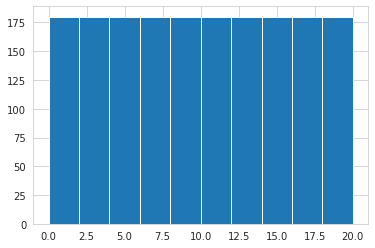

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [12]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
t = calibration_co_cons_labels
train_folds, train_target_folds, test_folds, test_target_folds = [],[],[],[]
for train_index, test_index in skf.split(np.zeros(len(t)), t):
    train_folds.append(calibration_features_matrix[train_index])
    train_target_folds.append(calibration_co_cons[train_index])
    test_folds.append(calibration_features_matrix[test_index])
    test_target_folds.append(calibration_co_cons[test_index])

plt.hist(train_target_folds[1])
plt.show()
train_folds[0] == train_folds[3]

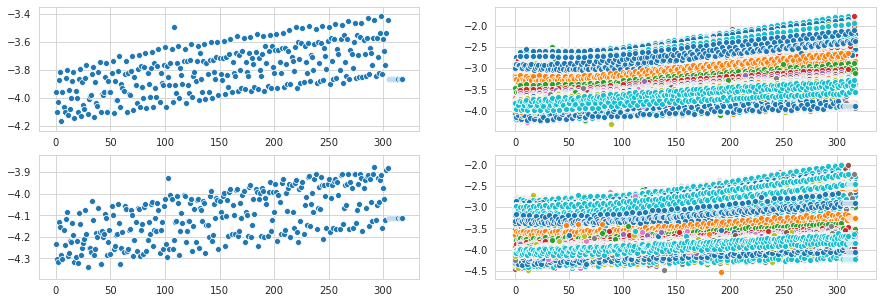

In [2]:
day = 1
fig, axes = plt.subplots(2,2, figsize=(15,5))
signalsample = 1
signalconc = target_sets[day-1][signalsample]
signal = features_sets[day-1][signalsample,:]
nsig = len(signal)
sns.scatterplot(np.arange(nsig),signal, ax=axes[0,0])

signalconcs = target_sets[day-1]
signals = features_sets[day-1]
nsig = len(signals)
for signal in signals[:100]:
    nsig = len(signal)
    sns.scatterplot(np.arange(nsig),signal, ax=axes[0,1])

day = 13
signalsample = 1
signalconc = target_sets[day-1][signalsample]
signal = features_sets[day-1][signalsample,:]
nsig = len(signal)
sns.scatterplot(np.arange(nsig),signal, ax=axes[1,0])

signalconcs = target_sets[day-1]
signals = features_sets[day-1]
nsig = len(signals)
for signal in signals[:100]:
    nsig = len(signal)
    sns.scatterplot(np.arange(nsig),signal, ax=axes[1,1])
plt.show()

## Projection to latent structures modelling
A.K.A Projection least squares  
using linear part of the logarithmic transformed sensor response signal

In [10]:
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

signals = calibration_features_matrix
targets = calibration_co_cons

#X = signals
#y = calibration_co_cons

#test_size = 0.2
#X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_test , y_train, y_test = train_folds[9], test_folds[9], train_target_folds[9], test_target_folds[9]

#kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

rmse = []

min_lv = 1
max_lv = 20
comprange = np.arange(min_lv, max_lv)
for i in comprange:
    str_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    train_labels = list(map(str,y_train))
    skf = str_kf.split(np.zeros(len(train_labels)), train_labels)
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, X_train, y_train, cv=skf, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(-score))

print(np.array(rmse))

[2.76011435 2.53707507 2.38553754 2.26383355 2.14427971 2.08926243
 1.99690067 1.97019905 1.94771601 1.94936926 1.9747067  1.97218728
 1.98980995 1.99699692 2.00358904 2.01021216 2.02289962 2.0283268
 2.03595466]


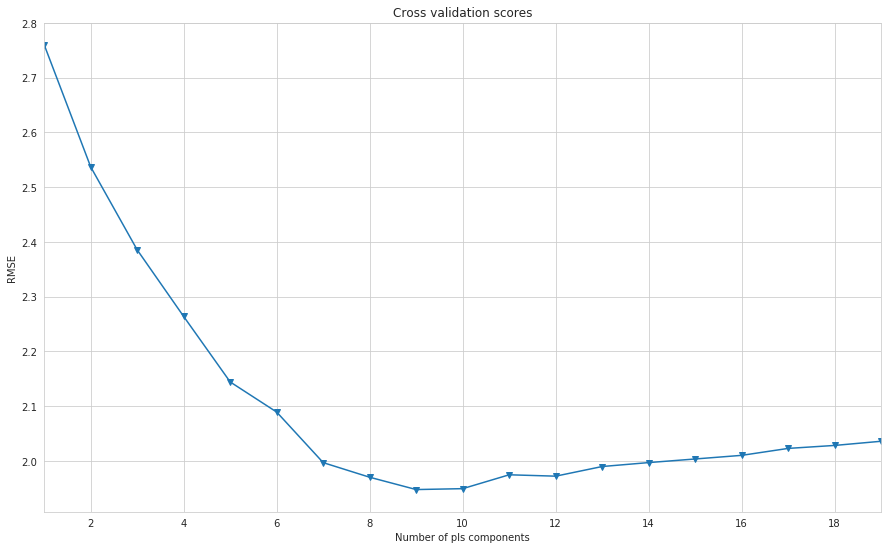

In [11]:
# Models complexity scores plot
plt.figure(figsize=(15,9))
plt.plot(comprange, np.array(rmse), '-v')
plt.xlabel('Number of pls components')
plt.ylabel('RMSE')
plt.title('Cross validation scores')
plt.xlim((min_lv,max_lv-1))
plt.show()

Slope: 0.8971797335928171
Intercept: 1.2255604212559408

Root mean squared error: 1.8755166470677938

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              7791.
Date:                Fri, 27 Sep 2019   Prob (F-statistic):                   1.54e-161
Time:                        08:12:58   Log-Likelihood:                         -409.22
No. Observations:                 200   AIC:                                      820.4
Df Residuals:                     199   BIC:                                      823.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 c

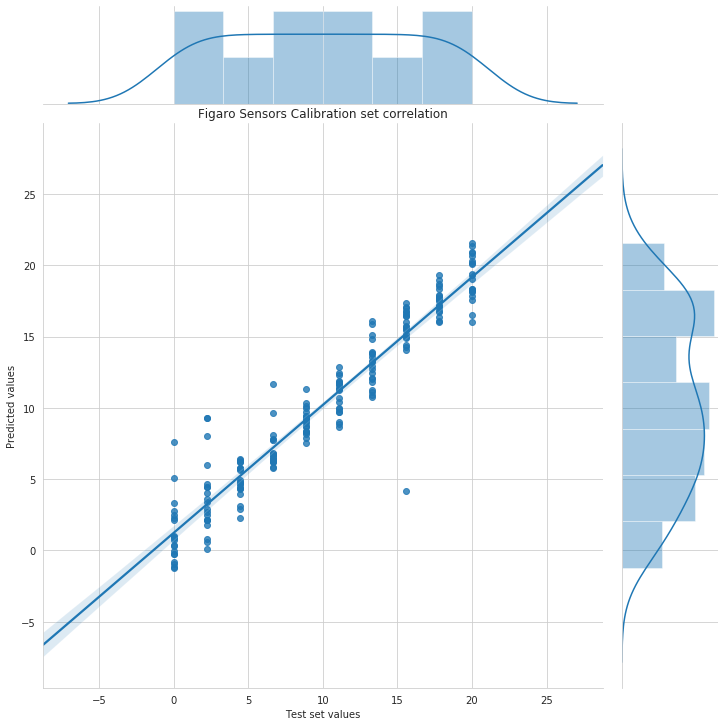

In [9]:
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

signals = calibration_features_matrix
targets = calibration_co_cons

X = signals
y = calibration_co_cons

#test_size = 0.2
#X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_test , y_train, y_test = train_folds[9], test_folds[9], train_target_folds[9], test_target_folds[9]

pls = PLSRegression(n_components=9)
pls.fit(X_train, y_train)

n = len(X_test)
Y_pred = np.array(pls.predict(X_test)).reshape(n)
y_test = np.array(y_test).reshape(n)
rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
p, residuals, rank, singular_values, rcond = np.polyfit(y_test, Y_pred, 1, full=True)
results = sm.OLS(y_test, Y_pred).fit()
print("Slope: " + str(p[0]) + "\nIntercept: " + str(p[1]))
print("")
print('Root mean squared error: ' + str(rmse))
print("")
print(results.summary())

# Correlation plot
sns.jointplot(y_test,Y_pred, kind='reg', height=10)
plt.title("Figaro Sensors Calibration set correlation")
plt.ylabel("Predicted values")
plt.xlabel("Test set values")
plt.savefig('images/cal_corr.png',dpi=100)
plt.show()

# Model validation
Suggesting long term stability of output quality

Root mean squared error: 1.9249594131444219
Slope: 1.1524175726676538
Intercept: -1.2301600681187703

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.024e+05
Date:                Wed, 25 Sep 2019   Prob (F-statistic):                        0.00
Time:                        01:42:19   Log-Likelihood:                         -4014.3
No. Observations:                2020   AIC:                                      8031.
Df Residuals:                    2019   BIC:                                      8036.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 c

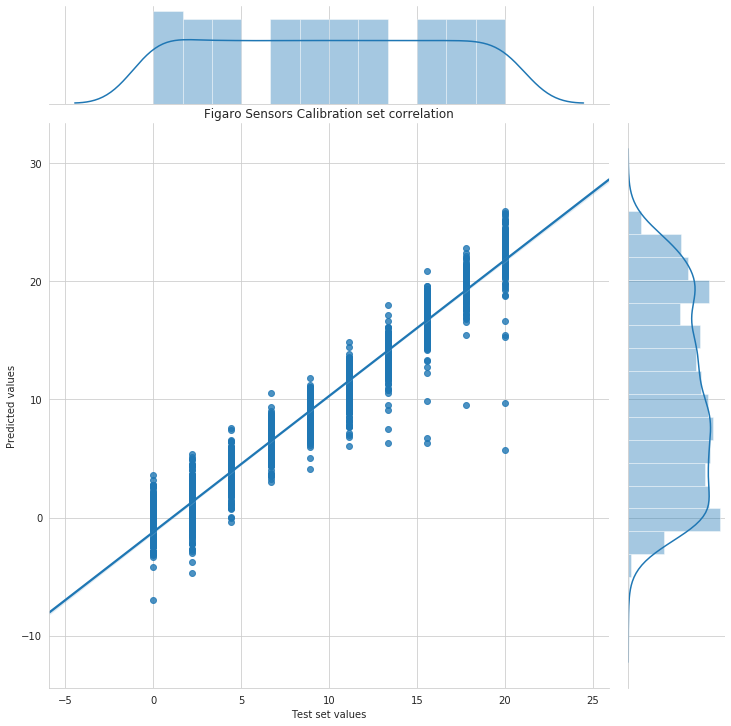

In [9]:
day = 13

val_features_matrix = features_sets[day-1]
val_co_cons = target_sets[day-1]

X = val_features_matrix
y = val_co_cons
n = len(X)
Y_pred = np.array(pls.predict(X)).reshape(n)
y_eval = np.array(y).reshape(n)

rmse = np.sqrt(mean_squared_error(y_eval, Y_pred))
p, residuals, rank, singular_values, rcond = np.polyfit(y_eval,Y_pred, 1, full=True)
results = sm.OLS(Y_pred,y_eval).fit()
print('Root mean squared error: ' + str(rmse))
print("Slope: " + str(p[0]) + "\nIntercept: " + str(p[1]))
print("")
print(results.summary())

# Correlation plot
sns.jointplot(y_eval,Y_pred, kind='reg', height=10)
plt.title("Figaro Sensors Calibration set correlation")
plt.ylabel("Predicted values")
plt.xlabel("Test set values")
plt.savefig('images/val_corr.png',dpi=100)
plt.show()

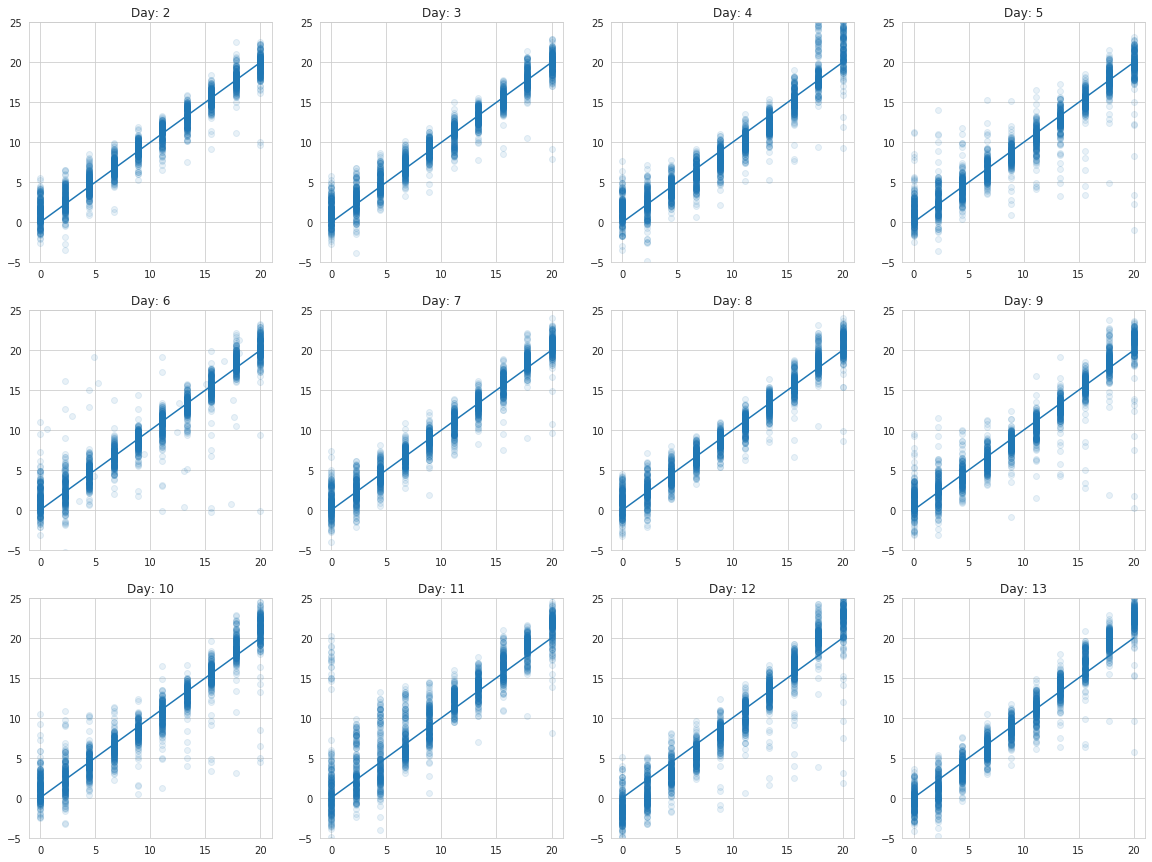

In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

fig, axes = plt.subplots(3,4, figsize=(20,15))
row = 0
slopes, intercepts, MSE, r2 = [],[],[],[]
for i in range(1,13):
    val_features_matrix = features_sets[i]
    val_co_cons = target_sets[i]

    X = val_features_matrix
    y = val_co_cons
    n = len(X)
    Y_pred = np.array(pls.predict(X)).reshape(n)
    y_eval = np.array(y).reshape(n)

    x = y_eval.reshape(len(y_eval))
    y = Y_pred.reshape(len(Y_pred))
    p = np.polyfit(x, y, 1)
    slopes.append(p[0])
    intercepts.append(p[1])
    MSE.append(mean_squared_error(x,y))
    r2.append(r2_score(x,y))
    
    col = (i-1)%4
    axes[row,col].scatter(x,y,alpha=0.1)
    axes[row,col].plot(np.arange(0,21),np.arange(0,21))
    axes[row,col].set_title("Day: " + str(i+1))
    axes[row,col].set_ylim((-5,25))
    if i%4 == 0 and i != 0:
        row+=1

plt.show()

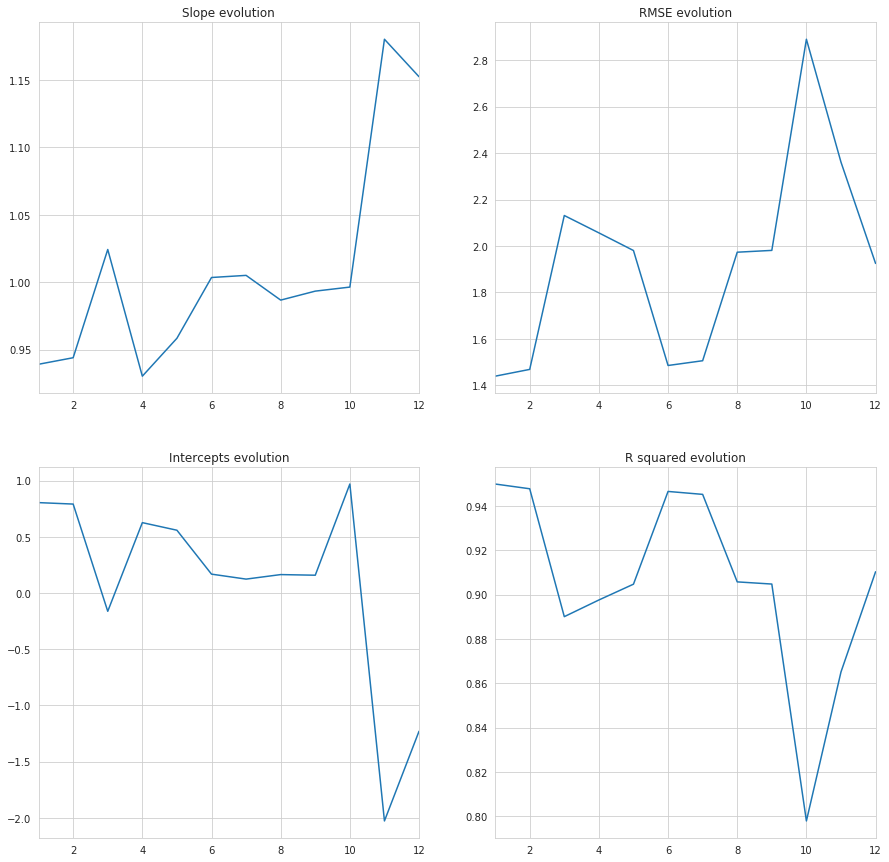

In [78]:
fig, axes = plt.subplots(2,2, figsize = (15,15))
plotrange = np.arange(1,13)

axes[0,0].plot(plotrange,slopes)
axes[0,0].set_title("Slope evolution")
axes[0,0].set_xlim((1,12))

axes[1,0].plot(plotrange,intercepts)
axes[1,0].set_title("Intercepts evolution")
axes[1,0].set_xlim((1,12))

axes[0,1].plot(plotrange,np.sqrt(MSE))
axes[0,1].set_title("RMSE evolution")
axes[0,1].set_xlim((1,12))

axes[1,1].plot(plotrange,r2)
axes[1,1].set_title("R squared evolution")
axes[1,1].set_xlim((1,12))

plt.show()